# Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pickle
import os
from contextlib import redirect_stdout

import warnings
warnings.filterwarnings('always')

In [2]:
# load the final dataframe from data_prep 
df_fulldata = pd.read_csv('diabetic_data_df.csv')

In [3]:
# Load columns to use from data_prep
col2use = pd.read_csv('col2use.csv')
col2use = col2use['col2use'].tolist()

df_data = df_fulldata[col2use]

In [4]:
df_data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Asian,race_Caucasian,...,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK,age_group,has_weight
0,1,41,0,1,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,3,59,0,18,0,0,0,9,0,1,...,0,0,0,0,0,0,0,1,10,0
2,2,11,5,13,2,0,1,6,0,0,...,0,0,0,0,0,0,0,1,20,0
3,2,44,1,16,0,0,0,7,0,1,...,0,0,0,0,0,0,0,1,30,0
4,1,51,0,8,0,0,0,5,0,1,...,0,0,0,0,0,0,0,1,40,0


In [5]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

#print ('OUTPUT_LABEL' in df_data.columns.tolist())

In [6]:
#split dataset 
# -> stratified split
# -> 80% train
#    -> k-fold (k=4)
# -> 20% test
#    -> confusion matrix
#    -> accuracy
#    -> sensitivity
#    -> recall

#X = df_data.values #input
#Y = df_fulldata['OUTPUT_LABEL'].values

Y_o_no  = np.where(df_fulldata['OUTPUT_LABEL'].values == 0)[0]
Y_o_yes = np.where(df_fulldata['OUTPUT_LABEL'].values == 1)[0]

class_names = {1:'yes', 0:'no'}
names = ['no', 'yes']

#original dataset
print ('==> Size classes:')
for c in np.unique(df_fulldata['OUTPUT_LABEL'].values):
    s = np.sum(df_fulldata['OUTPUT_LABEL'].values == c).astype(np.float)
    print ('\t{:4} [{:1}] => {:5} => {:3}'.format(class_names[c], c,\
                                                  s, round(s/len(df_fulldata['OUTPUT_LABEL'].values), 3)))
    
#stratified dataset
print ('==> Size stratified') #~50% yes 50%no
i_y_no = np.random.choice(range(0, len(Y_o_no)), len(Y_o_yes))
X = np.concatenate((df_data.values[Y_o_yes], df_data.values[Y_o_no[i_y_no]]), axis=0)
Y = np.concatenate((df_fulldata['OUTPUT_LABEL'].values[Y_o_yes], \
                    df_fulldata['OUTPUT_LABEL'].values[Y_o_no[i_y_no]]), axis=0)

for c in np.unique(Y):
    s = np.sum(Y == c).astype(np.float)
    print ('\t{:4} [{:1}] => {:5} => {:3}'.format(class_names[c], c, s, round(s/len(Y), 3)))

#split dataset: train and test
X_train, X_test, Y_train,  Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y) 

#normalized data
#normalized data
scaler  = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


print ('==> Dataset split:')
print ('\ttrain => input={} | output={}'.format(X_train.shape, Y_train.shape))
print ('\ttest  => input={}  | output={}'.format(X_test.shape, Y_test.shape))

==> Size classes:
	no   [0] => 88029.0 => 0.886
	yes  [1] => 11314.0 => 0.114
==> Size stratified
	no   [0] => 11314.0 => 0.5
	yes  [1] => 11314.0 => 0.5
==> Dataset split:
	train => input=(18102, 143) | output=(18102,)
	test  => input=(4526, 143)  | output=(4526,)


# Methods

In [7]:
from sklearn.metrics import classification_report, accuracy_score, \
                            average_precision_score, f1_score, precision_score,\
                            recall_score, roc_auc_score, log_loss, confusion_matrix

def report(y_true, y_pred, prefix):
    accuracy = accuracy_score(y_true, y_pred)
    ap      = average_precision_score(y_true, y_pred)
    f1      = f1_score(y_true, y_pred)
    lloss   = log_loss(y_true, y_pred)
    prec    = precision_score(y_true, y_pred)
    recall  = recall_score(y_true, y_pred)
    auc     = roc_auc_score(y_true, y_pred)
    
    print ('{} Accuracy :{:3}'.format(prefix, accuracy))
    print ('{} AP:       {:3}'.format(prefix, ap))
    print ('{} F1-score :{:3}'.format(prefix, f1))
    print ('{} Log-Loss :{:3}'.format(prefix, lloss))
    print ('{} Precision:{:3}'.format(prefix, prec))
    print ('{} Recall   :{:3}'.format(prefix, recall))
    print ('{} AUC      :{:3}'.format(prefix, auc))
    
    return accuracy

def make_confusion_matrix(y_true, y_pred, names, normalized, prefix='', path=''):
    
    title = 'Confusion Matrix'
    cm = confusion_matrix(y_true, y_pred)
     
    if normalized:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=names, 
           yticklabels=names,
           ylabel='True Label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
                                   rotation_mode='anchor')
    
    fmt = '.2f' if normalized else 'd'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='green')#'white' if cm[i,j] > thresh else 'black')
    
    fig.tight_layout()
    
    if path != '':
        plt.savefig(path)
        
    plt.show()  

# Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

_dt = DecisionTreeClassifier()
dt = None

### training

In [11]:
kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

print ('==> training Decision Tree:')
iteration = 0
best_acc  = 0
for itrain, ivalid in kfold.split(X_train, Y_train):
    print ('\t\033[94m iteration {}\033[0m'.format(iteration))
    
    #split dataset into train and valid, based on folds
    xi_train, xi_valid = X_train[itrain], X_train[ivalid]
    yi_train, yi_valid = Y_train[itrain], Y_train[ivalid]
    print ('\t\t train size: input= {} | output= {}'.format(xi_train.shape, yi_train.shape))
    print ('\t\t valid size: input= {} | output= {}'.format(xi_valid.shape, yi_valid.shape))
        
    #train
    _dt.fit(xi_train, yi_train)
    
    #valid
    y_train_predicted = _dt.predict(xi_train)
    y_valid_predicted = _dt.predict(xi_valid)
        
    #report
    print ('\t\t report train:')
    report(y_true=yi_train, y_pred=y_train_predicted, prefix='\t\t\t')
    print ('\t\t report valid:')
    acc = report(y_true=yi_valid, y_pred=y_valid_predicted, prefix='\t\t\t')
    
    with open('models/dtree/report_train_dtree_{}.txt'.format(iteration), 'w') as f:
         with redirect_stdout(f):
                report(y_true=yi_train, y_pred=y_train_predicted, prefix='')
    with open('models/dtree/report_valid_dtree_{}.txt'.format(iteration), 'w') as f:
         with redirect_stdout(f):          
                report(y_true=yi_valid, y_pred=y_valid_predicted, prefix='')
    
    if acc > best_acc:
        best_acc = acc
        dt = _dt
        
        with open('models/dtree/best_dtree_model.txt', 'w') as f:
            f.write(str(iteration))
    
    with open('models/dtree/dtree_{}'.format(iteration), 'wb') as f:
        f.write(pickle.dumps(_dt))
          
    iteration += 1

==> training Decision Tree:
	 iteration 0
		 train size: input= (13576, 143) | output= (13576,)
		 valid size: input= (4526, 143) | output= (4526,)
		 report train:
			 Accuracy :1.0
			 AP:       1.0
			 F1-score :1.0
			 Log-Loss :9.992007221626413e-16
			 Precision:1.0
			 Recall   :1.0
			 AUC      :1.0
		 report valid:
			 Accuracy :0.5293857711003094
			 AP:       0.515580733700164
			 F1-score :0.5228494623655914
			 Log-Loss :16.254622294499022
			 Precision:0.530213539300318
			 Recall   :0.515687140963323
			 AUC      :0.5293857711003094
	 iteration 1
		 train size: input= (13576, 143) | output= (13576,)
		 valid size: input= (4526, 143) | output= (4526,)
		 report train:
			 Accuracy :1.0
			 AP:       1.0
			 F1-score :1.0
			 Log-Loss :9.992007221626413e-16
			 Precision:1.0
			 Recall   :1.0
			 AUC      :1.0
		 report valid:
			 Accuracy :0.49889527176314624
			 AP:       0.4994489021908772
			 F1-score :0.4896489648964896
			 Log-Loss :17.307737256661206
			 Precision:0

### test

==> test K Nearest Neighbors
	 Report 
	 Accuracy :0.5238621299160406
	 AP:       0.5125265155196961
	 F1-score :0.5132143663880733
	 Log-Loss :16.445401042242764
	 Precision:0.5249537892791127
	 Recall   :0.5019885108263368
	 AUC      :0.5238621299160406


	 Normalized Confusion Matrix 


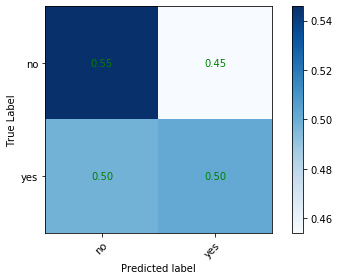

	 Unnormalized Confusion Matrix 


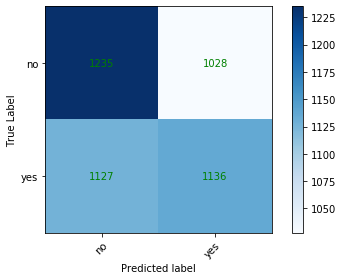

In [12]:
y_test_predicted = dt.predict(X_test)

print ('==> test K Nearest Neighbors')
print ('\t\033[94m Report \033[0m')
report(Y_test, y_test_predicted, prefix='\t')
with open('models/dtree/report_test_dt.txt', 'w') as f:
    with redirect_stdout(f):          
        report(y_true=Y_test, y_pred=y_test_predicted, prefix='')
        
print ('\n')
print ('\t\033[94m Normalized Confusion Matrix \033[0m')
make_confusion_matrix(y_true=Y_test, 
                      y_pred=y_test_predicted, 
                      names=['no', 'yes'], 
                      normalized=True,
                      path='models/dtree/normalized_cm.png')
print ('\t\033[94m Unnormalized Confusion Matrix \033[0m')
make_confusion_matrix(y_true=Y_test, 
                      y_pred=y_test_predicted, 
                      names=['no', 'yes'], 
                      normalized=False,
                      path='models/dtree/unnormalized_cm.png')